# Titanic Logistic Regression
Load the database [Titanic Data Set da Kaggle](https://www.kaggle.com/c/titanic)

In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sc= SparkContext()
sqlContext = SQLContext(sc)

titanic = pd.read_csv('titanic_train.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


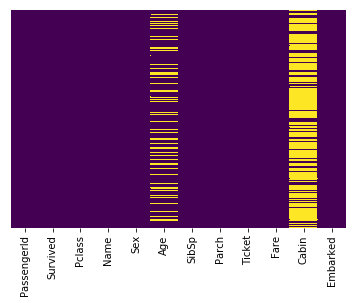

In [2]:
sns.heatmap(titanic.isnull(),yticklabels=False,cbar=False,cmap='viridis')

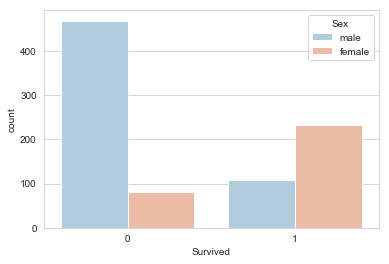

In [3]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=titanic,palette='RdBu_r')

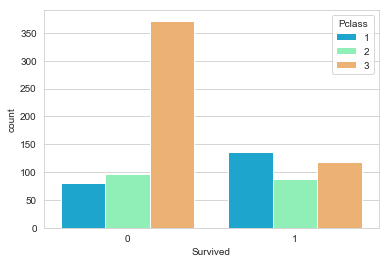

In [4]:
sns.countplot(x='Survived', hue='Pclass', data=titanic, palette='rainbow')

## Handle incomplete columns
Complete the age feature with the mean by class and delete the cabin feature

In [5]:
titanic.drop('Cabin',axis=1,inplace=True)

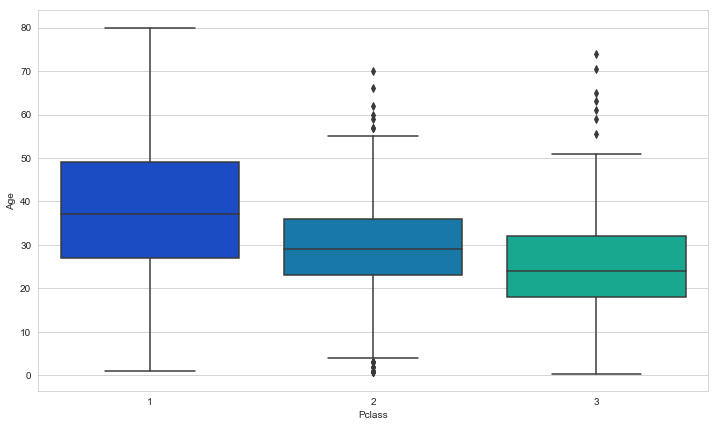

In [6]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=titanic,palette='winter')

In [7]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age
    
titanic['Age'] = titanic[['Age','Pclass']].apply(impute_age,axis=1)

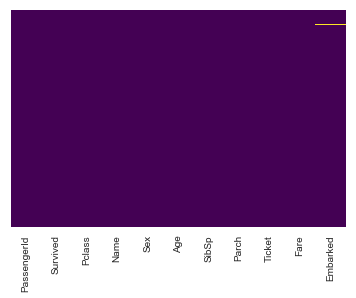

In [8]:
sns.heatmap(titanic.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [9]:
titanic.dropna(inplace=True)

titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [10]:
sex = pd.get_dummies(titanic['Sex'], drop_first=True)
embark = pd.get_dummies(titanic['Embarked'], drop_first=True)
titanic.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)
titanic = pd.concat([titanic,sex,embark],axis=1)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 10 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
male           889 non-null uint8
Q              889 non-null uint8
S              889 non-null uint8
dtypes: float64(2), int64(5), uint8(3)
memory usage: 58.2 KB


In [11]:
titanic.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


## Parse the dataset to Spark and split it

In [12]:
data = sqlContext.createDataFrame(titanic)
data.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'male',
 'Q',
 'S']

In [13]:
import functools
oldColumns = data.schema.names
newColumns = ['PassengerId',
              'label',
              'Pclass',
              'Age',
              'SibSp',
              'Parch',
              'Fare',
              'male',
              'Q',
              'S']

df = functools.reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]),
            range(len(oldColumns)), data)
df.printSchema()
df.show(3)

root
 |-- PassengerId: long (nullable = true)
 |-- label: long (nullable = true)
 |-- Pclass: long (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: long (nullable = true)
 |-- Parch: long (nullable = true)
 |-- Fare: double (nullable = true)
 |-- male: long (nullable = true)
 |-- Q: long (nullable = true)
 |-- S: long (nullable = true)

+-----------+-----+------+----+-----+-----+-------+----+---+---+
|PassengerId|label|Pclass| Age|SibSp|Parch|   Fare|male|  Q|  S|
+-----------+-----+------+----+-----+-----+-------+----+---+---+
|          1|    0|     3|22.0|    1|    0|   7.25|   1|  0|  1|
|          2|    1|     1|38.0|    1|    0|71.2833|   0|  0|  0|
|          3|    1|     3|26.0|    0|    0|  7.925|   0|  0|  1|
+-----------+-----+------+----+-----+-----+-------+----+---+---+
only showing top 3 rows



In [33]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = ['PassengerId',
                                                'Pclass',
                                                'Age',
                                                'SibSp',
                                                'Parch',
                                                'Fare',
                                                'male',
                                                'Q',
                                                'S'], outputCol = 'features')
vData = vectorAssembler.transform(df)
vData = vData.select(['features', 'label'])
vData.show(3)
vData.select(['label']).distinct().show()
vData.printSchema()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.0,3.0,22.0,1.0...|    0|
|[2.0,1.0,38.0,1.0...|    1|
|[3.0,3.0,26.0,0.0...|    1|
+--------------------+-----+
only showing top 3 rows

+-----+
|label|
+-----+
|    0|
|    1|
+-----+

root
 |-- features: vector (nullable = true)
 |-- label: long (nullable = true)



In [34]:
train, test = vData.randomSplit([0.7, 0.3])

print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))
train.printSchema()

Training Dataset Count: 617
Test Dataset Count: 272
root
 |-- features: vector (nullable = true)
 |-- label: long (nullable = true)



## Create the Logit Regression model

In [16]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=50)
lrModel = lr.fit(train)

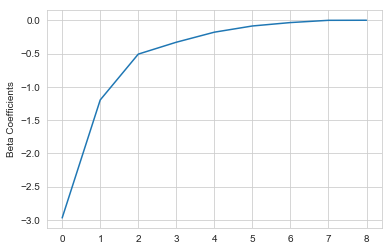

In [17]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

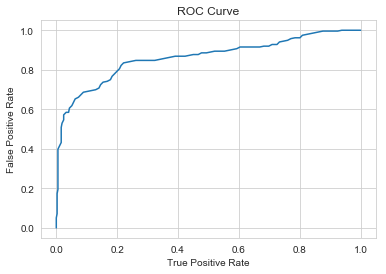

Training set areaUnderROC: 0.8621453698204578


In [18]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

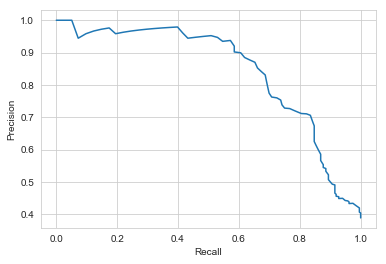

In [19]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

## Make predictions on the test set and evaluate the results

In [20]:
predictions = lrModel.transform(test)
predictions.select('label', 'rawPrediction',
                   'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|    0|[-2.7170990803342...|       1.0|[0.06197188657621...|
|    1|[-2.3460796169885...|       1.0|[0.08737789022835...|
|    0|[2.64844436505084...|       0.0|[0.93391504502909...|
|    1|[-0.4258178331882...|       1.0|[0.39512543531440...|
|    0|[-0.1241780737436...|       1.0|[0.46899531285267...|
|    1|[1.41755641900823...|       0.0|[0.80495505415715...|
|    1|[-1.3490944470978...|       1.0|[0.20601845805077...|
|    0|[2.26257679157911...|       0.0|[0.90572987607513...|
|    1|[-2.7032108363322...|       1.0|[0.06278415759966...|
|    0|[-0.1049210064142...|       1.0|[0.47379378473350...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))
# println(eva.confusionMatrix)

Test Area Under ROC 0.8378889369057906


In [22]:
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] ==
                               maxFMeasure['max(F-Measure)']).select('threshold').head()['threshold']


In [23]:
# Overall statistics
print("Summary Stats")
print('Accuracy = %s' % str(trainingSummary.accuracy))
print("Precision = %s" % trainingSummary.precisionByLabel)
print("F1 Score = %s" % trainingSummary.fMeasureByLabel())
print("False Positive = %s" % trainingSummary.falsePositiveRateByLabel)
print("Recall = %s" % trainingSummary.recallByLabel)


Summary Stats
Accuracy = 0.8056013179571664
Precision = [0.821882951653944, 0.7757009345794392]
F1 Score = [0.8455497382198952, 0.7377777777777778]
False Positive = [0.2966101694915254, 0.1293800539083558]
Recall = [0.8706199460916442, 0.7033898305084746]


In [32]:
from pyspark.mllib.evaluation import MulticlassMetrics

pred = predictions.select('prediction', 'label')
metricsp = MulticlassMetrics(pred.rdd)
# metricsp.recall(1)

tp = pred[(pred.label == 1) & (pred.prediction == 1)].count()
tn = pred[(pred.label == 0) & (pred.prediction == 0)].count()
fp = pred[(pred.label == 0) & (pred.prediction == 1)].count()
fn = pred[(pred.label == 1) & (pred.prediction == 0)].count()
print("True Positives: %f" % tp)
print("True Negatives: %f" % tn)
print("False Positives: %f" % fp)
print("False Negatives: %f" % fn)
print("Total: %d" % pred.count())

r = float(tp)/(tp + fn)
print("recall %f" % r)

p = float(tp) / (tp + fp)
print("precision %f" % p)


True Positives: 75.000000
True Negatives: 146.000000
False Positives: 32.000000
False Negatives: 29.000000
Total: 282
recall 0.721154
precision 0.700935
